In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box
import rioxarray
from sklearn.cluster import DBSCAN
import folium
import matplotlib.colors as mcolors
from random import sample

from src.utils import SentinelDownloader, read_neon_trees

root = Path.cwd()

### Read in tree location data

In [2]:
# set path variables
site_folder = '2019_BART_5' #'2019_HARV_6'
site = 'BART'
epsg = "EPSG:26919"

bart_trees = read_neon_trees(root,site,epsg=epsg)


### Map tree locations

In [121]:

# choose point to serve as map center coordinates
map_coords = tuple(bart_trees.to_crs(4326).get_coordinates().iloc[37,]) # get xy coords for index 37
map_coords = tuple([map_coords[1],map_coords[0]]) # switch them around because everything is integrated seamlessly

beech = bart_trees.loc[bart_trees.taxonID=='FAGR']
nonbeech = bart_trees.loc[bart_trees.taxonID!='FAGR']

# plot results
m = folium.Map(location=map_coords, zoom_start=11)

folium.GeoJson(
    df.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="blue", fill_opacity=0.4, color="blue", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["cluster"])
).add_to(m)

# folium.GeoJson(
#     nonbeech.to_crs(4326),
#     marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1),
#     tooltip=folium.GeoJsonTooltip(fields=["taxonID"])
# ).add_to(m)

# # add buffers to map
# # folium.GeoJson(
# #     s.to_crs(4326)
# # ).add_to(m)

# folium.GeoJson(
#     polys,
#     style_function=lambda x:{
#          "fillColor": "red"
#         if x['properties']["Name"] == 'non-beech stand'
#         else "orange",
#         "color":"red"
#         if x['properties']["Name"] == 'non-beech stand'
#         else "orange"},
#     tooltip=folium.GeoJsonTooltip(fields=["Name","index"])
# ).add_to(m)

m

### Download Sentinel Data

In [4]:
b = SentinelDownloader(2019,bart_trees,epsg=26919)

number of low cloud images: 60


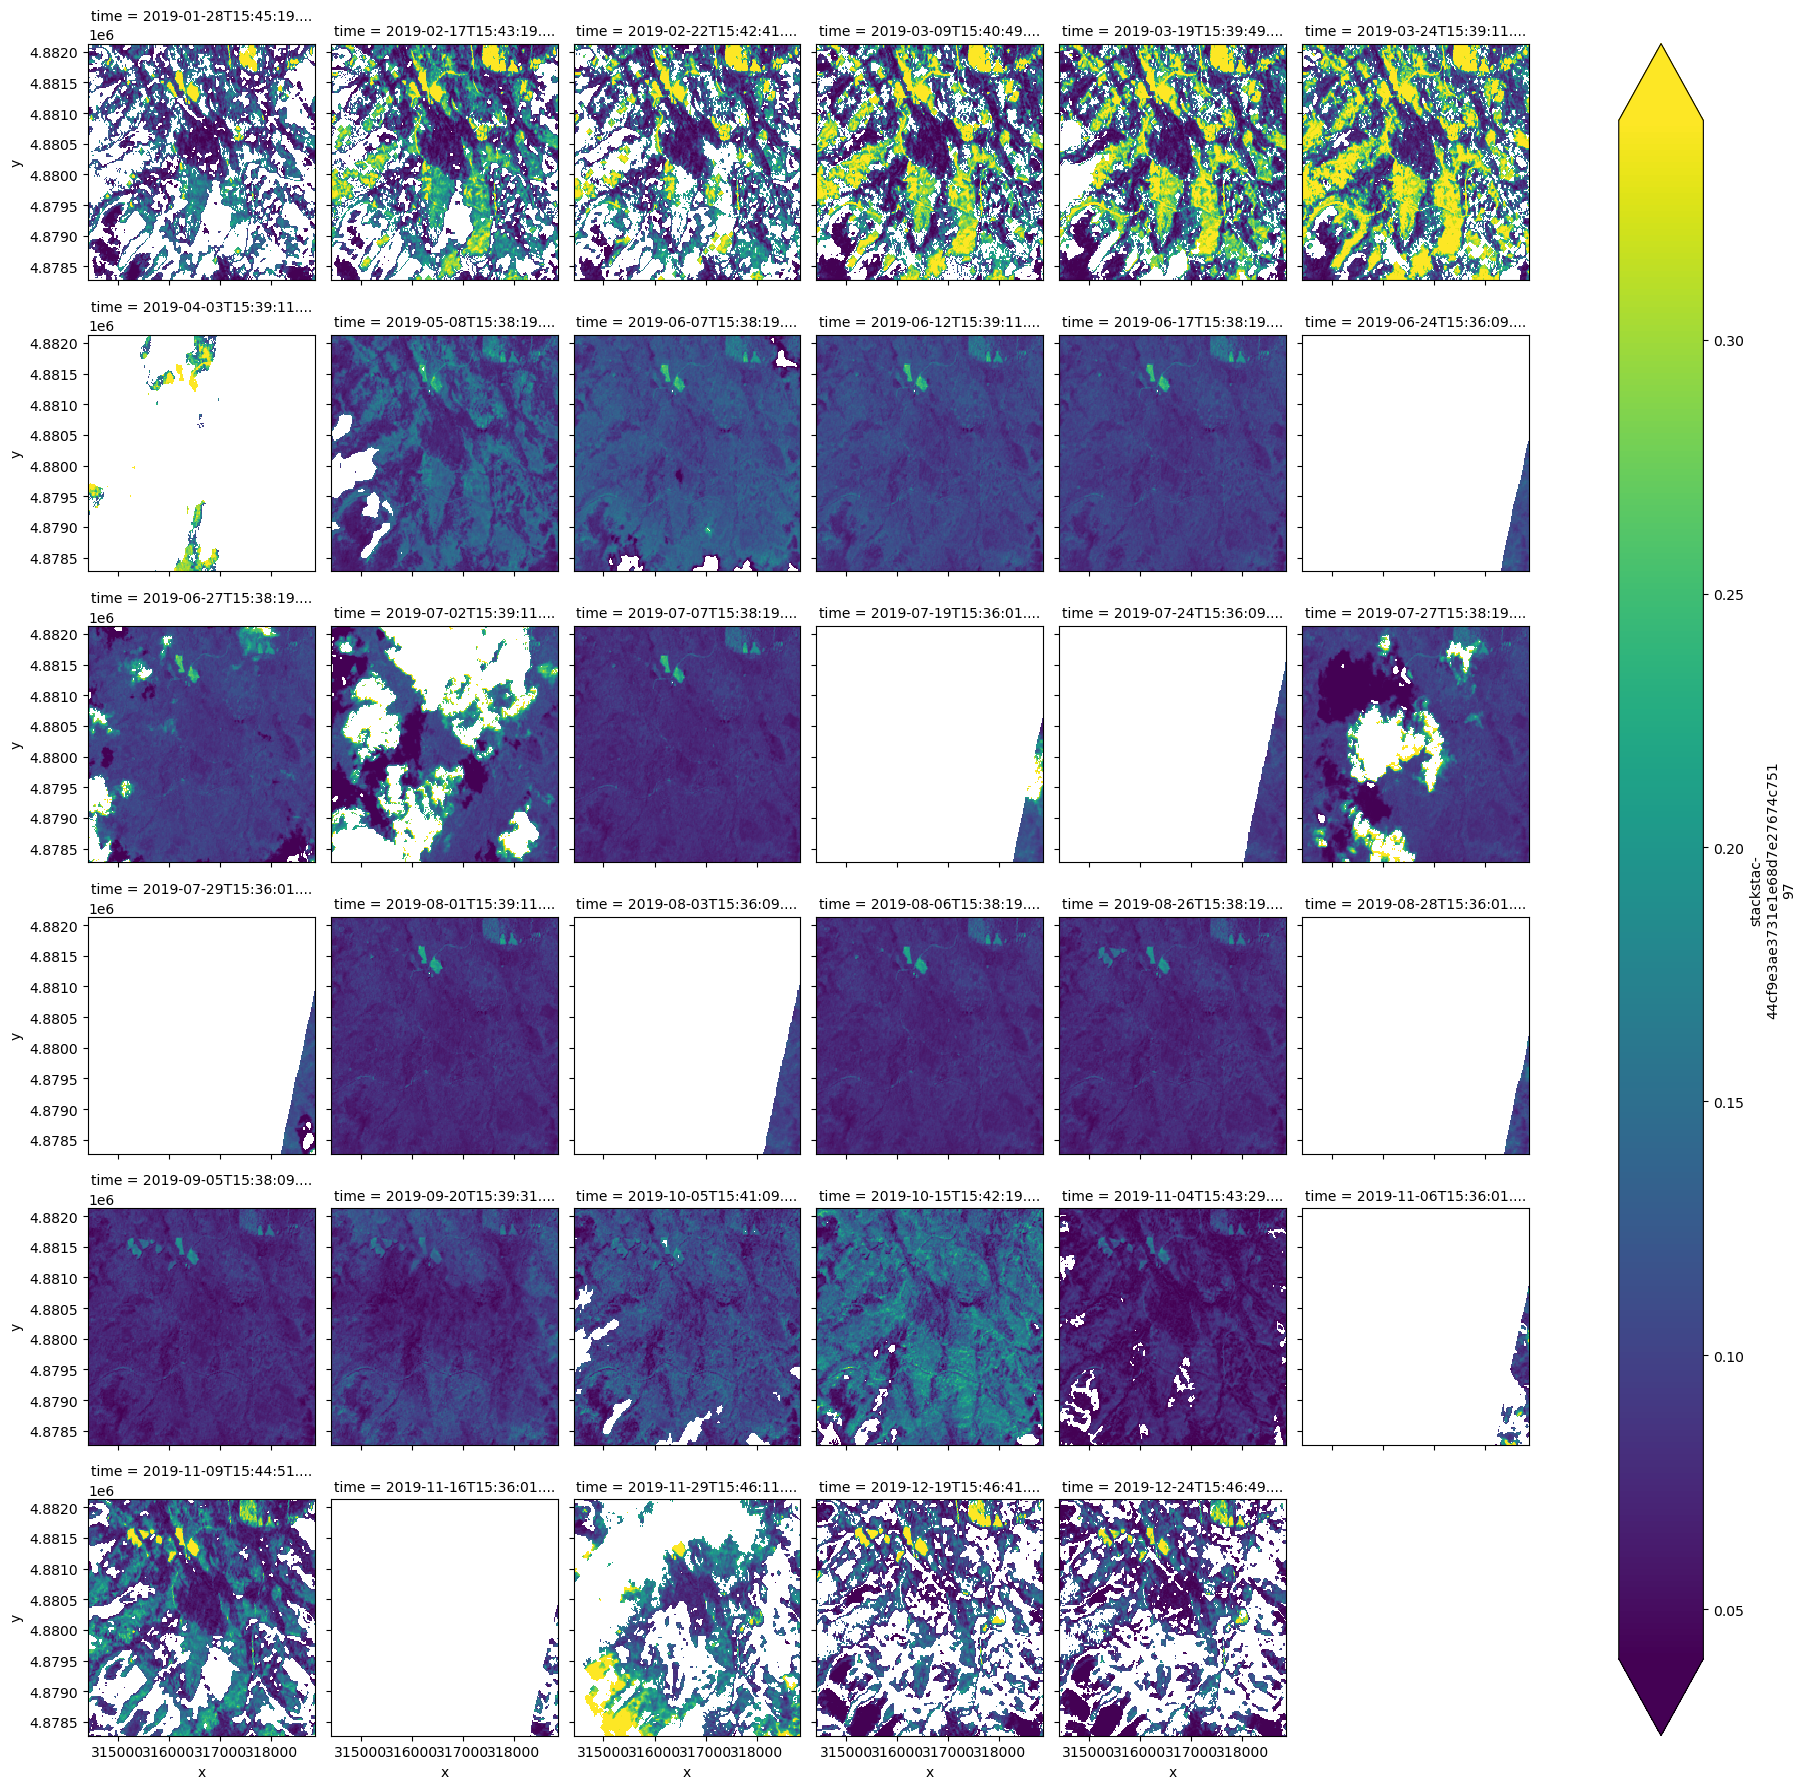

In [14]:
b.plot_initial_data()

In [5]:
b.missing_data = [6,11,15,16,18,20,23,29,31]
b.drop_missing_data()
b.save_bands_data(root,'2019_bart')
b.get_indices()
b.save_vi_data(root,'2019_bart')

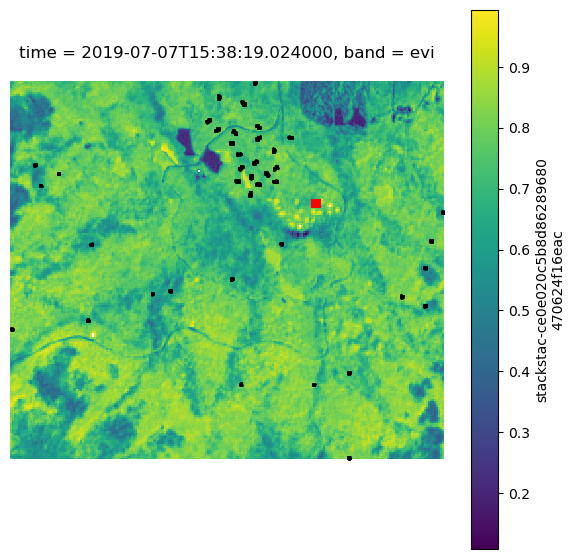

In [50]:
# plot trees overlaid with sentinel data
fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

im = b.indices.isel(band=1,time=12)
#img = xr.apply_ufunc(exposure.rescale_intensity, img)

im.plot.imshow(ax=ax)
bart_trees.plot(ax=ax,color='black',markersize=1)


ax.set_axis_off()

### Plot trees by cluster

In [ ]:
# read in saved sentinel data
n = xr.open_dataarray(root / 'sentinel_data' / '2019_bart_indices.nc')
n = n.rio.write_crs(26919).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

In [7]:
# cluster points together
bart_trees['x'] = bart_trees.geometry.x #Create a x coordinate column (with units in meters)
bart_trees['y'] = bart_trees.geometry.y

coords = bart_trees[['x','y']].values #Create a numpy array where each row is a coordinate pair

db = DBSCAN(eps=20, min_samples=8).fit(coords)
cluster_labels = pd.Series(db.labels_).rename('cluster') #A series with all points cluster ids

c_df = pd.concat([bart_trees, cluster_labels], axis=1) #concat it to the dataframe

C:\Users\roseh\AppData\Local\Temp\ipykernel_11256\4117859733.py:29: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  beech.plot(ax=axe[i],color='blue',markersize=1)
C:\Users\roseh\AppData\Local\Temp\ipykernel_11256\4117859733.py:29: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  beech.plot(ax=axe[i],color='blue',markersize=1)
C:\Users\roseh\AppData\Local\Temp\ipykernel_11256\4117859733.py:29: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  beech.plot(ax=axe[i],color='blue',markersize=1)
C:\Users\roseh\AppData\Local\Temp\ipykernel_11256\4117859733.py:29: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  beech.plot(ax=axe[i],color='blue',markersize=1)


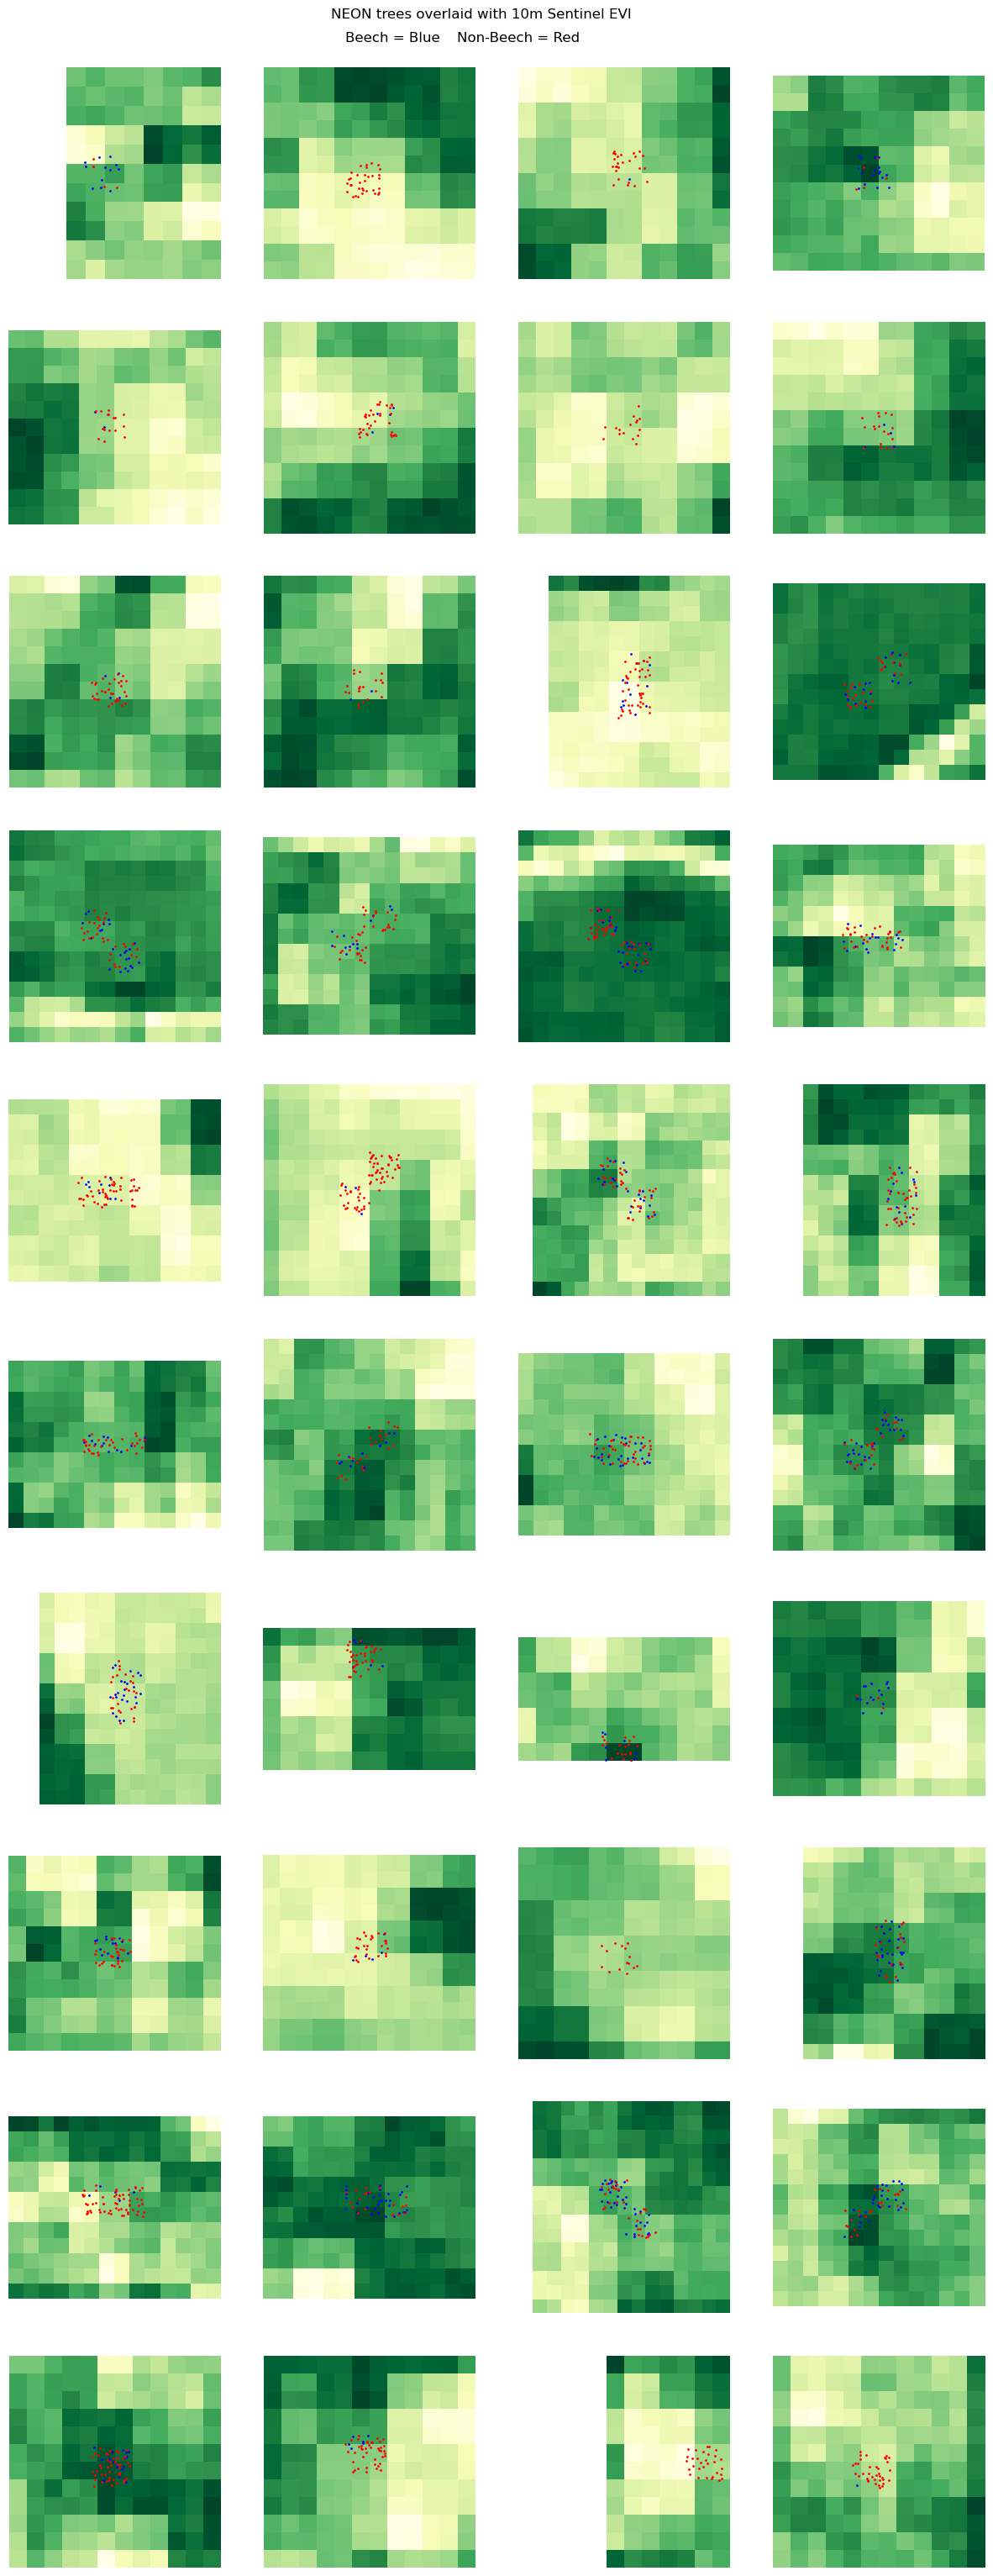

In [143]:
fig, axs = plt.subplots(ncols=4,nrows=10,figsize=(15,35))
fig.subplots_adjust(top=0.96)
fig.suptitle("NEON trees overlaid with 10m Sentinel EVI")
plt.text(0.43, 0.97, 'Beech = Blue', ha='center', va='center', transform=fig.transFigure, fontsize=12)
plt.text(0.53, 0.97, 'Non-Beech = Red', ha='center', va='center', transform=fig.transFigure, fontsize=12)

axe = axs.ravel()
# get boundary of point cluster
for i in range(0,40):
    c = c_df.loc[c_df.cluster==i]
    c_buff = c.buffer(50)
    clip_df = gpd.GeoDataFrame(
        geometry=[box(*c_buff.total_bounds)],
        crs="EPSG:26919"
    )

    # clip sentinel data patch for cluster

    clipped_raster = n.rio.clip(clip_df.geometry.values, crs=26919, drop=True, invert=False)

    # identify pixels the overlap with all beech/non-beech points (using index of points)
    beech = c.loc[c['taxonID']=='FAGR']
    nonbeech = c.loc[c['taxonID']!= 'FAGR']


    #plt.imshow(clipped_raster.isel(band=1,time=12),ax=axe[i],cmap='YlGn')
    p = clipped_raster.isel(band=1,time=12).plot(ax=axe[i],cmap='YlGn')
    p.colorbar.remove()
    beech.plot(ax=axe[i],color='blue',markersize=1)
    nonbeech.plot(ax=axe[i],color='red',markersize=1)
    axe[i].axis('off')
    axe[i].set_title("")

plt.show()


